TEMAT NR 1: PRZEWIDYWANIE CENY DOMOW (dane AMES)

POBRANIE NIEZBEDNYCH PAKIETOW I DANYCH DO ANALIZY

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn import model_selection
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, ElasticNet,Ridge,LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
import scipy.stats as stats

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data=pd.read_csv("ames2000_NAfix.csv")

In [3]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

OCZYSZCZANIE DANYCH

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

In [5]:
#Generalny podglad typow danych i unikalnych wartosci w kazdej kolumnie 
d={} 
for i in range(len(data.columns)):
    d.update({data.columns[i]:data[data.columns[i]].unique()})
d

{'MS.SubClass': array([120,  20,  85,  90,  60,  70,  50,  80, 160, 190,  45,  30,  75,
        180,  40, 150]),
 'MS.Zoning': array(['RL', 'RM', 'C (all)', 'FV', 'I (all)', 'A (agr)', 'RH'],
       dtype=object),
 'Lot.Frontage': array(['34', '70', '60', '64', '111', '50', '155', 'None', '55', '51',
        '42', '75', '52', '24', '59', '79', '85', '65', '58', '83', '84',
        '100', '80', '63', '89', '112', '38', '77', '174', '39', '87',
        '125', '44', '81', '86', '97', '93', '118', '102', '78', '57',
        '69', '67', '116', '68', '101', '48', '73', '43', '32', '92', '54',
        '76', '91', '88', '90', '95', '40', '71', '72', '62', '130', '82',
        '21', '120', '114', '99', '105', '104', '35', '47', '98', '53',
        '61', '66', '94', '41', '74', '110', '115', '36', '117', '134',
        '30', '141', '49', '96', '124', '37', '129', '128', '107', '33',
        '108', '182', '136', '56', '113', '103', '46', '149', '26', '109',
        '45', '313', '135', '121', '126

In [6]:
#Braki w danych dotycza kolumn zwiaznych z piwnica, garazem oraz typem zamurowanie. Poniewaz nie ma duzo brakow w danych i kolumny sa powiazane mozemy podejrzec dane i skorygowac.

In [7]:
#Oczyszczanie danych dotyczacych piwnicy
#Filtrujemy braki danych w kolumnach (wszystkie braki widoczne sa ponizej)

In [8]:
data.loc[data['Bsmt.Exposure'].isnull(),'Bsmt.Qual':'Total.Bsmt.SF']

Bsmt.Qual Bsmt.Cond Bsmt.Exposure BsmtFin.Type.1 BsmtFin.SF.1  \
553         Gd        TA           NaN            Unf            0   
682        NaN       NaN           NaN            NaN         None   
1490        Gd        TA           NaN            Unf            0   

     BsmtFin.Type.2 BsmtFin.SF.2 Bsmt.Unf.SF Total.Bsmt.SF  
553             Unf            0         936           936  
682             NaN         None        None          None  
1490            Unf            0         725           725

In [9]:
data.loc[data['BsmtFin.Type.2'].isnull(),'Bsmt.Qual':'Total.Bsmt.SF']

Bsmt.Qual Bsmt.Cond Bsmt.Exposure BsmtFin.Type.1 BsmtFin.SF.1  \
682       NaN       NaN           NaN            NaN         None   
769        Gd        TA            No            GLQ         1124   

    BsmtFin.Type.2 BsmtFin.SF.2 Bsmt.Unf.SF Total.Bsmt.SF  
682            NaN         None        None          None  
769            NaN          479        1603          3206

In [10]:
#Sprawdzamy najczesciej wystepujaca wartosc w kolumnach 'Bsmt.Exposure' oraz 'BsmtFin.Type.2'
pd.value_counts(data['Bsmt.Exposure'])

No      1306
Av       285
Gd       188
Mn       166
None      52
Name: Bsmt.Exposure, dtype: int64

In [11]:
pd.value_counts(data['BsmtFin.Type.2'])

Unf     1694
Rec       70
LwQ       67
None      52
BLQ       50
ALQ       38
GLQ       27
Name: BsmtFin.Type.2, dtype: int64

In [12]:
#Oczyszczanie danych dotyczacych piwnicy
#Jezeli 'Total.Bsmt.SF' ="None" (brak piwnicy) to pole powierzchni garazu ustawiamy na 0
#W przypadku braku piwnicy pola 'Bsmt.Qual','Bsmt.Cond','BsmtFin.SF.1','BsmtFin.SF.2','Bsmt.Unf.SF' ustawiamy na 0
#W przypadku braku piwnicy pola 'Bsmt.Exposure','BsmtFin.Type.1','BsmtFin.Type.2' ustawiamy na 'None'
#W przypadku braku lazienki w piwnicy: pole "None" ustawiamy na 0
data.loc[data['Total.Bsmt.SF'] == "None", 'Total.Bsmt.SF'] = 0
data.loc[data['Total.Bsmt.SF'] ==0,['Bsmt.Qual','Bsmt.Cond','BsmtFin.SF.1','BsmtFin.SF.2','Bsmt.Unf.SF']]=0.0
data.loc[data['Total.Bsmt.SF'] ==0 ,['Bsmt.Exposure','BsmtFin.Type.1','BsmtFin.Type.2']] = 'None'
data.loc[data['Bsmt.Full.Bath'] == "None", 'Bsmt.Full.Bath'] = 0
data.loc[data['Bsmt.Half.Bath'] == "None", 'Bsmt.Half.Bath'] = 0
#Pozostale braki uzupelniamy najczesciej wystepujaca wartoscia w kolumnie
data['Bsmt.Exposure'].fillna('No',inplace=True)
data['BsmtFin.Type.2'].fillna('Unf',inplace=True)


In [14]:
#Oczyszczenie danych zwiazanych z typem zamurowanie. 
#Filtrujmy wszystkie brakujace dane w kolumnie "Mas.Vnr.Type" i powiazana kolumne "Mas.Vnr.Area" "
data.loc[data['Mas.Vnr.Type'].isnull(),'Mas.Vnr.Type':'Mas.Vnr.Area']

Mas.Vnr.Type Mas.Vnr.Area
37            NaN         None
50            NaN         None
221           NaN         None
280           NaN         None
426           NaN         None
472           NaN         None
509           NaN         None
521           NaN         None
636           NaN         None
657           NaN         None
941           NaN         None
1056          NaN         None
1321          NaN         None
1358          NaN         None
1475          NaN         None
1878          NaN         None

In [15]:
#Jezeli powierzchnia zamurowania ==None to kolumnie "Mas.Vnr.Area" przypisujemy wartosc 0 
#Jezeli powierzchnia zamurowania ==0 to typ zamurowania ustawiamy na "None" (brak zamurowania)
data.loc[data['Mas.Vnr.Area']=="None",'Mas.Vnr.Area']=0
data.loc[data['Mas.Vnr.Area']==0,'Mas.Vnr.Type']="None"

In [16]:
#Oczyszczenie danych zwiazanych z garazem
#Filtrujemy braki danych w kolumnie "Garage.Finish" i powiazane kolumny (wszystkie braki danych widoczne sa ponizej)
data.loc[data['Garage.Finish'].isnull(),'Garage.Type':'Garage.Cond']

Garage.Type Garage.Yr.Blt Garage.Finish Garage.Cars Garage.Area  \
362      Detchd          None           NaN           1         360   
511      Detchd          None           NaN        None        None   

    Garage.Qual Garage.Cond  
362        None        None  
511         NaN         NaN

In [17]:
#Wartoscia 'None' w kolumnie "Garage.Yr.Blt" przypisujemy wartosc liczbowa 0 (brak garazu)
#W przypadku braku garazu kolumny 'Garage.Area','Garage.Qual','Garage.Cond','Garage.Cars' ustawiamy na 0
#W przypadku braku garazu kolumny 'Garage.Type','Garage.Finish' ustawiamy na 'None'
data.loc[data['Garage.Yr.Blt'] == "None", 'Garage.Yr.Blt'] = 0
data.loc[data['Garage.Yr.Blt'] ==0,['Garage.Area','Garage.Qual','Garage.Cond','Garage.Cars']]=0
data.loc[data['Garage.Yr.Blt'] ==0 ,['Garage.Type','Garage.Finish']]="None"

In [18]:
#Wartosci "None" w kolumnie "Lot.Frontage" zamieniamy na wartosc 0
data.loc[data['Lot.Frontage'] == "None", 'Lot.Frontage'] = 0

In [19]:
#Stworzenie ratingu munerycznego dla wybrancych kolumn
changed_columns=['Exter.Qual','Exter.Cond','Bsmt.Qual','Bsmt.Cond','Heating.QC','Kitchen.Qual','Fireplace.Qu','Garage.Qual','Garage.Cond','Pool.QC']

In [20]:
for i in range(len(changed_columns)):
    column=changed_columns[i]
    data.loc[:,column].replace(to_replace={
     'Ex': 5,
     'Gd': 4,
     'TA': 3,
     'Fa': 2,
     'Po': 1,
     'None': 0
    }, inplace=True)   

In [21]:
#zmiana typu danych z 'object' na 'int' dla kolumn, w ktrych sa wartosci liczbowe
data[['Lot.Frontage','Mas.Vnr.Area','BsmtFin.SF.1','BsmtFin.SF.2','Bsmt.Unf.SF','Total.Bsmt.SF','Bsmt.Full.Bath','Bsmt.Half.Bath','Garage.Yr.Blt','Garage.Cars','Garage.Area']]=data[['Lot.Frontage','Mas.Vnr.Area','BsmtFin.SF.1','BsmtFin.SF.2','Bsmt.Unf.SF','Total.Bsmt.SF','Bsmt.Full.Bath','Bsmt.Half.Bath','Garage.Yr.Blt','Garage.Cars','Garage.Area']].astype('int64')


In [22]:
#Pozostale przeksztalcenia:
#Utworzenie kolumny 'House.Age'- "Wiek" domu w momencie sprzedazy
#Utworzenie kolumny 'House.Age.Remod'- kolumna okresla ile lat minelo od ostatniego remontu
#Utowrzenie kolumny 'Garage.Yr.Blt'- "Wiek" garazu w momencie sprzedazy domu (jeeli brak garazu wartosc 0)
data['House.Age']=data['Yr.Sold']-data['Year.Built']
data['House.AgeRemod']=data['Yr.Sold']-data['Year.Remod.Add']
data.loc[data['Garage.Yr.Blt'] !=0 ,'Garage.Yr.Blt']=data['Yr.Sold']-data['Garage.Yr.Blt']
#Zmiana kolumn kategoryzujacych na kolumny "zerojedynkowe". (zbadanie i uwzglednienie w modelowaniu wpywu np. lokalizacji (Neighbourhood) na cene domu)
data_dummies=pd.get_dummies(data[['Street','Central.Air','MS.SubClass','MS.Zoning','Alley','Lot.Shape','Land.Contour','Lot.Config','Land.Slope','Neighborhood','Condition.1','Condition.2','Bldg.Type','House.Style','Roof.Style','Roof.Matl','Exterior.1st','Exterior.2nd','Mas.Vnr.Type','Foundation','Bsmt.Exposure','BsmtFin.Type.1','BsmtFin.Type.2','Heating','Electrical','Functional','Garage.Type','Garage.Finish','Paved.Drive','Fence','Misc.Feature','Sale.Type','Sale.Condition']])
#Usuniecie kolumn kategoryzujacych oraz:
#Usuniecie kolumny 'Utilities'- Dla kazdego wiersza kolumna przyjmuje wartosc 'AllPub'-brak wplywu na modelowanie
#Usuniecie kolumn Yr.Sold','Year.Remod.Add','Year.Built'- kolumny zamienione na 'House.Age','House.AgeRemod','Garage.Yr.Blt' oraz usuniecie kolumny 'Mo.Sold'
data=data.drop(['Yr.Sold','Year.Remod.Add','Year.Built','Mo.Sold','Utilities','Central.Air','MS.SubClass','MS.Zoning','Street','Alley','Lot.Shape','Land.Contour','Utilities','Lot.Config','Land.Slope','Neighborhood','Condition.1','Condition.2','Bldg.Type','House.Style','Roof.Style','Roof.Matl','Exterior.1st','Exterior.2nd','Mas.Vnr.Type','Foundation','Bsmt.Exposure','BsmtFin.Type.1','BsmtFin.Type.2','Heating','Electrical','Functional','Garage.Type','Garage.Finish','Paved.Drive','Fence','Misc.Feature','Sale.Type','Sale.Condition'],axis=1,)

In [23]:
#Polaczenie danych numerycznych z "zerojedynkowymi"
data_cleaned = pd.concat([data, data_dummies], axis=1)

In [24]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 261 entries, Lot.Frontage to Sale.Condition_Partial
dtypes: float64(2), int64(43), uint8(216)
memory usage: 1.1 MB


In [25]:
#Podglad danych po przeksztalceniech
d={}
for i in range(len(data_cleaned.columns)):
   d.update({data_cleaned.columns[i]:data_cleaned[data_cleaned.columns[i]].unique()})
d

{'Lot.Frontage': array([ 34,  70,  60,  64, 111,  50, 155,   0,  55,  51,  42,  75,  52,
         24,  59,  79,  85,  65,  58,  83,  84, 100,  80,  63,  89, 112,
         38,  77, 174,  39,  87, 125,  44,  81,  86,  97,  93, 118, 102,
         78,  57,  69,  67, 116,  68, 101,  48,  73,  43,  32,  92,  54,
         76,  91,  88,  90,  95,  40,  71,  72,  62, 130,  82,  21, 120,
        114,  99, 105, 104,  35,  47,  98,  53,  61,  66,  94,  41,  74,
        110, 115,  36, 117, 134,  30, 141,  49,  96, 124,  37, 129, 128,
        107,  33, 108, 182, 136,  56, 113, 103,  46, 149,  26, 109,  45,
        313, 135, 121, 126, 133,  22, 153,  25, 150, 138, 140, 152, 106,
        160, 195, 168,  28]),
 'Lot.Area': array([ 3901,  8400,  7200, ..., 10367, 10142,  7252]),
 'Overall.Qual': array([ 6,  4,  5,  9,  8,  7, 10,  3,  1,  2]),
 'Overall.Cond': array([5, 8, 9, 6, 1, 2, 7, 4, 3]),
 'Mas.Vnr.Area': array([ 182,    0,  370,  244,  123,  260,   50,  970,  630,  113,  156,
         299,  242,

ANALIZA ZMIENNEJ OBJASNIANEJ, ZMIENNYCH OBJASNIAJACYCH ORAZ WYBOR CECH DO MODELU

WSTEPNA ANALIZA ROZKLADOW ORAZ ZALEZNOSCI NA PODSTAWIE WYKRESU PAIRPLOT

In [26]:
sns.pairplot(data)

<Figure size 432x288 with 0 Axes>

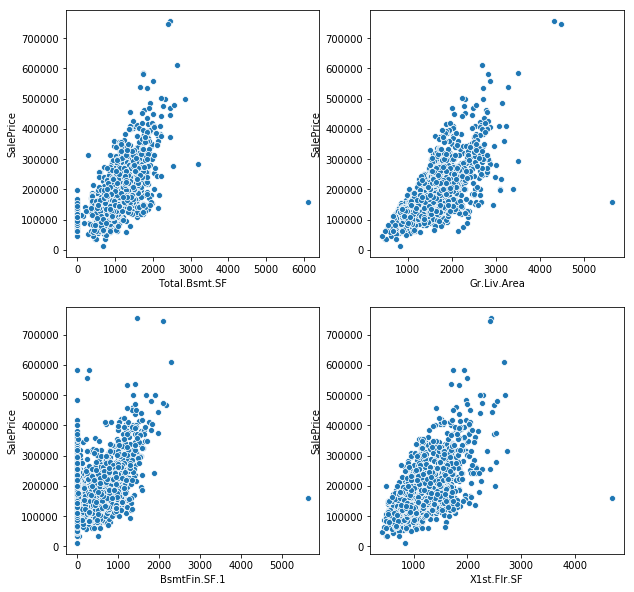

In [27]:
#Wstepnie analizujemy zaleznosc zmiennej 'SalePrice' od innych zmiennych. Dla ponizszych zmiennych zauwazamy zaleznosc i wartosci odstajace 'outliers'
plt.figure(1)
plt.figure(figsize=(10,10))

plt.subplot(221)
sns.scatterplot(data_cleaned['Total.Bsmt.SF'],data_cleaned["SalePrice"])
plt.subplot(222)
sns.scatterplot(data_cleaned['Gr.Liv.Area'],data_cleaned["SalePrice"])
plt.subplot(223)
sns.scatterplot(data_cleaned['BsmtFin.SF.1'],data_cleaned["SalePrice"])
plt.subplot(224)
sns.scatterplot(data_cleaned['X1st.Flr.SF'],data_cleaned["SalePrice"])

In [28]:
#Ze wzgledu na obostrzenie w zadaniu 'ze nie usuwamy zadnych obserwacji', wartosci odstajace zamieniamy na wartosc srednia ze zmiennej
data_cleaned.loc[data_cleaned['Gr.Liv.Area']>5000, 'Gr.Liv.Area'] = np.mean(data_cleaned['Gr.Liv.Area'])
data_cleaned.loc[data_cleaned['Total.Bsmt.SF']>5000, 'Total.Bsmt.SF'] = np.mean(data_cleaned['Total.Bsmt.SF'])
data_cleaned.loc[data_cleaned['BsmtFin.SF.1']>5000, 'BsmtFin.SF.1'] = np.mean(data_cleaned['BsmtFin.SF.1'])
data_cleaned.loc[data_cleaned['X1st.Flr.SF']>4000, 'X1st.Flr.SF'] = np.mean(data_cleaned['X1st.Flr.SF'])

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

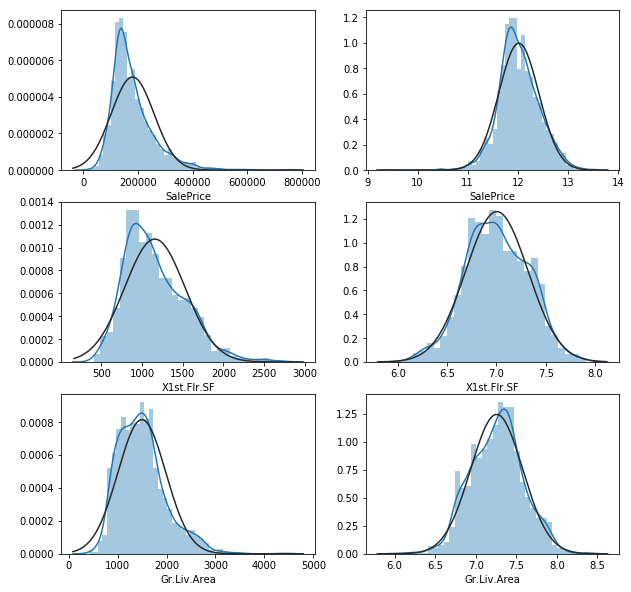

In [29]:
#Logarytmujemy dane o rozkladach skosnych (na podstawie powyzszych histogramow)
plt.figure(1)
plt.figure(figsize=(10,10))
plt.subplot(321)
sns.distplot(data_cleaned['SalePrice'], fit=stats.norm)
plt.subplot(322)
sns.distplot(np.log(data_cleaned['SalePrice']), fit=stats.norm)
plt.subplot(323)
sns.distplot(data_cleaned['X1st.Flr.SF'], fit=stats.norm)
plt.subplot(324)
sns.distplot(np.log(data_cleaned['X1st.Flr.SF']), fit=stats.norm)
plt.subplot(325)
sns.distplot(data_cleaned['Gr.Liv.Area'], fit=stats.norm)
plt.subplot(326)
sns.distplot(np.log(data_cleaned['Gr.Liv.Area']), fit=stats.norm)

In [30]:
data_cleaned['SalePrice']=np.log(data_cleaned['SalePrice'])
data_cleaned['Gr.Liv.Area']=np.log(data_cleaned['Gr.Liv.Area'])
data_cleaned['X1st.Flr.SF']=np.log(data_cleaned['X1st.Flr.SF'])

Ze wzgledu na kwestie wydajnosciowe korzystajac z RandomForestRegressor ograniczamy ilosc zmiennych z 258 do 60 najbardziej istotnych zmiennych w modelowaniu. (Przetestowano takze ilosc 20, 40, 60 - porownujac wyniki koncowe najlepsze dopasowanie uzyskujemy przy zbiorze 60 elementowym)

In [31]:
X=data_cleaned.drop('SalePrice',axis=1)
y=data_cleaned['SalePrice']

In [32]:
seed=333
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=seed)

In [33]:
rf=RandomForestRegressor(n_estimators=100,random_state=seed)
rf.fit(X_train,y_train)
features=pd.Series(rf.feature_importances_,index=X.columns).nlargest(60).index
features

Index(['Overall.Qual', 'Gr.Liv.Area', 'Garage.Cars', 'Total.Bsmt.SF',
       'Garage.Area', 'X1st.Flr.SF', 'Lot.Area', 'BsmtFin.SF.1',
       'Overall.Cond', 'House.Age', 'Kitchen.Qual', 'House.AgeRemod',
       'X2nd.Flr.SF', 'Open.Porch.SF', 'Fireplace.Qu', 'Bsmt.Unf.SF',
       'Bsmt.Qual', 'Lot.Frontage', 'Garage.Yr.Blt', 'Central.Air_N',
       'Mas.Vnr.Area', 'Central.Air_Y', 'Wood.Deck.SF', 'MS.SubClass',
       'Full.Bath', 'Garage.Type_Detchd', 'TotRms.AbvGrd', 'Fireplaces',
       'Bedroom.AbvGr', 'Heating.QC', 'MS.Zoning_RM', 'MS.Zoning_C (all)',
       'MS.Zoning_RL', 'Bsmt.Full.Bath', 'Garage.Finish_Unf', 'Enclosed.Porch',
       'Exter.Cond', 'Sale.Condition_Normal', 'Sale.Condition_Abnorml',
       'Garage.Cond', 'Exterior.1st_AsbShng', 'Screen.Porch', 'Exter.Qual',
       'Exterior.1st_Wd Sdng', 'Bsmt.Cond', 'Paved.Drive_N', 'Half.Bath',
       'Paved.Drive_Y', 'Exterior.2nd_AsbShng', 'BsmtFin.SF.2',
       'Neighborhood_Edwards', 'Foundation_PConc', 'Exterior.2nd_Wd Sd

In [34]:
#Utworzenie selected_features dataframe skladajacego sie z wyselekcjonowanych zmiennych objasniajacych i zmiennej objasnianej
selected_features=pd.concat([data_cleaned.loc[:,features],data_cleaned['SalePrice']],axis=1)

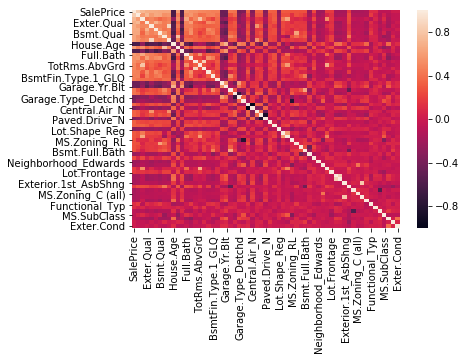

In [35]:
#Wyswietlenie heatmapy korelacji zmiennych zawartych w selected_features dataframe (sortowanie zmiennych wedlug najwyzszej korelacji ze zmienna 'SalePrice') 
h_map=selected_features.corr()
h_map_sorted=list(np.abs(h_map['SalePrice']).sort_values(ascending=False).index)
sns.heatmap(selected_features.loc[:,h_map_sorted].corr())
plt.rcParams["figure.figsize"] = (40,30)

In [36]:
#Podglad korelacji miedzy zmienncmi
selected_features.loc[:,h_map_sorted].corr()

SalePrice  Overall.Qual  Gr.Liv.Area  Exter.Qual  \
SalePrice                1.000000      0.832090     0.732423    0.677439   
Overall.Qual             0.832090      1.000000     0.597971    0.728191   
Gr.Liv.Area              0.732423      0.597971     1.000000    0.439962   
Exter.Qual               0.677439      0.728191     0.439962    1.000000   
Garage.Cars              0.667135      0.592477     0.496978    0.508579   
Kitchen.Qual             0.658041      0.661936     0.429396    0.699383   
Bsmt.Qual                0.641280      0.644943     0.350510    0.565805   
Total.Bsmt.SF            0.639978      0.539979     0.416126    0.447752   
Garage.Area              0.636458      0.556597     0.461717    0.492672   
House.Age               -0.623952     -0.603736    -0.279584   -0.616017   
X1st.Flr.SF              0.607777      0.455384     0.532585    0.348063   
House.AgeRemod          -0.590736     -0.575619    -0.336085   -0.606334   
Full.Bath                0.588671      0.529415     0.657270    0.487827   
Foundation_PConc         0.550685      0.573145     0.368492    0.607784   
Fireplace.Qu             0.544148      0.483274     0.492363    0.334475   
TotRms.AbvGrd            0.501802      0.384615     0.798507    0.276522   
Fireplaces               0.494536      0.400480     0.455255    0.235247   
Heating.QC               0.482648      0.466615     0.291887    0.519319   
BsmtFin.Type.1_GLQ       0.466183      0.469510     0.208245    0.460327   
Mas.Vnr.Area             0.461352      0.421785     0.378081    0.371950   
Garage.Finish_Unf       -0.447541     -0.440525    -0.301198   -0.431383   
Garage.Yr.Blt           -0.442013     -0.462155    -0.240741   -0.522476   
BsmtFin.SF.1             0.427743      0.275596     0.161898    0.216656   
Garage.Type_Attchd       0.413962      0.363049     0.196770    0.300386   
Garage.Type_Detchd      -0.402220     -0.346077    -0.283210   -0.305601   
MS.Zoning_RM            -0.360122     -0.226064    -0.168773   -0.222503   
Central.Air_Y            0.349563      0.272648     0.132627    0.206070   
Central.Air_N           -0.349563     -0.272648    -0.132627   -0.206070   
Garage.Cond              0.342291      0.289510     0.164428    0.188281   
Paved.Drive_Y            0.340709      0.289090     0.135965    0.213886   
Paved.Drive_N           -0.334803     -0.276526    -0.142408   -0.184157   
Wood.Deck.SF             0.331753      0.250349     0.228227    0.212307   
Open.Porch.SF            0.324715      0.307282     0.321204    0.282564   
Lot.Shape_Reg           -0.311853     -0.254659    -0.204143   -0.204222   
Half.Bath                0.305450      0.264962     0.431350    0.228163   
X2nd.Flr.SF              0.294305      0.258424     0.642046    0.181668   
MS.Zoning_RL             0.278464      0.128528     0.116140    0.098526   
Bsmt.Cond                0.275165      0.268605     0.077418    0.179497   
Bsmt.Exposure_Gd         0.272522      0.229278     0.115363    0.163036   
Bsmt.Full.Bath           0.271310      0.168736     0.042324    0.149242   
Bsmt.Exposure_No        -0.248691     -0.196495    -0.081124   -0.186329   
Lot.Area                 0.238788      0.084924     0.229688    0.045017   
Neighborhood_Edwards    -0.214189     -0.204749    -0.137066   -0.144211   
Neighborhood_IDOTRR     -0.211220     -0.149950    -0.101523   -0.144490   
Bedroom.AbvGr            0.187367      0.074959     0.535936   -0.030635   
Lot.Frontage             0.186456      0.146952     0.161901    0.129797   
Exterior.2nd_Wd Sdng    -0.183622     -0.175413    -0.073178   -0.213921   
Exterior.1st_Wd Sdng    -0.183409     -0.155837    -0.058937   -0.217033   
Exterior.1st_AsbShng    -0.179068     -0.144594    -0.070885   -0.080108   
Bsmt.Unf.SF              0.177205      0.255283     0.247931    0.233927   
Sale.Condition_Abnorml  -0.176746     -0.130543    -0.051925   -0.111219   
MS.Zoning_C (all)       -0.166354     -0.125918    -0.075170   -0.099771

In [37]:
#usuniecie z danych zmiennej objasnianej oraz zmiennych mocno skorelowanych z pozostalymi cechami np. w danych pozostawiono zmienna House.Age ktora jest silnie skorelowana ze zmienna 'House.AgeRemod'
#Standaryzacja danych objasniajacych
data_model=selected_features.drop(['SalePrice','TotRms.AbvGrd','Garage.Area','X1st.Flr.SF','Bsmt.Unf.SF','House.AgeRemod','Exter.Qual'],axis=1)
data_model_scaled = pd.DataFrame(StandardScaler().fit_transform(data_model))


MODELOWANIE I TUNOWANIE MODELI

In [38]:
#Podzial danych na zbior treningowy i testowy, tunowanie modeli regresyjnych
X=data_model_scaled
y=selected_features['SalePrice']
kfold = model_selection.KFold(n_splits=4, random_state=seed)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=seed)


In [39]:
grid1 = GridSearchCV(Ridge(max_iter=10000,random_state=seed),
                    param_grid={
                    'alpha': [0.0001,0.001,0.01,0.1,1,10,100,100]},
                    cv=kfold,
                    refit=True)
grid1.fit(X_train, y_train)
grid1.best_params_

{'alpha': 10}

In [40]:
grid2 = GridSearchCV(Lasso(max_iter=10000,random_state=seed),
                     param_grid={
                    'alpha':[0.00001,0.0001,0.001,0.01,1,10,100,1000]},
                    cv=kfold,
                    refit=True)
grid2.fit(X_train, y_train)
grid2.best_params_


{'alpha': 0.001}

In [52]:
grid3 = GridSearchCV(ElasticNet(max_iter=10000,random_state=seed),
                    param_grid={
                    'alpha': [0.000001,0.00001,0.0001,0.001,0.001,0.01,0.1,1,10,100],
                    'l1_ratio':[0.01,0.1,1,10,100,1000,10000]},
                    cv=kfold,
                    refit=True)
grid3.fit(X_train, y_train)
grid3.best_params_

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 1e-06, 'l1_ratio': 1000}

In [42]:
grid4=GridSearchCV(xgb.XGBRegressor(random_state=seed),
                     param_grid={
    "n_estimators": [10,100,1000,10000],
    "max_depth": [1,2,3,5],
    "learning_rate": [0.1,0.2,0.3,0.5]},
   # "min_child_weight":[0.3,0.7,1,1.5],
   # "colsample_bytree":[0.6,1]},
                     cv=kfold,
                     refit=True)
grid4.fit(X_train, y_train)
grid4.best_params_

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kodolamacz/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}

In [43]:
grid5=GridSearchCV(RandomForestRegressor(random_state=seed),
                   param_grid={
                   'n_estimators': [100,500,700,1000,5000],
                    'max_features': ['sqrt','log2'],  
                    'max_depth': [10,30,50,100,500]
                   },
                    cv=kfold,
                    refit=True)
grid5.fit(X_train, y_train)
grid5.best_params_

{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 1000}

In [53]:
#Kalkulacja miar R^2, RMSE, MSE, MAE dla danych testowych
models = []
models.append(('Ridge', grid1.best_estimator_))
models.append(('Lasso', grid2.best_estimator_))
models.append(('ElasticNet', grid3.best_estimator_))
models.append(('XGBRegressor', grid4.best_estimator_))
models.append(('RF', grid5.best_estimator_))
r2 = []
root_mean_squared_error = []
mean_squared_error = []
mean_absolute_error = []
model_names=[]
residuals=[]
for name, model in models:
    model_names.append(name)
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    root_mean_squared_error.append(np.sqrt(metrics.mean_squared_error(y_test, model.predict(X_test))))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))
    residuals.append(y_test-model.predict(X_test))

In [54]:
#Porownanie przetestowanych rozwiazan: miary R^2, RMSE, MSE, MAE
summary = {'METHOD':model_names,
     'R2': r2, 
     'RMSE': root_mean_squared_error, 
     'MSE' : mean_squared_error,
     'MAE' : mean_absolute_error,
    }
pd.DataFrame(data=summary)

METHOD        R2      RMSE       MSE       MAE
0         Ridge  0.929978  0.105620  0.011156  0.076567
1         Lasso  0.929918  0.105666  0.011165  0.077146
2    ElasticNet  0.929936  0.105653  0.011162  0.077176
3  XGBRegressor  0.920089  0.112832  0.012731  0.081166
4            RF  0.910076  0.119693  0.014326  0.082658

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 2880x2160 with 0 Axes>

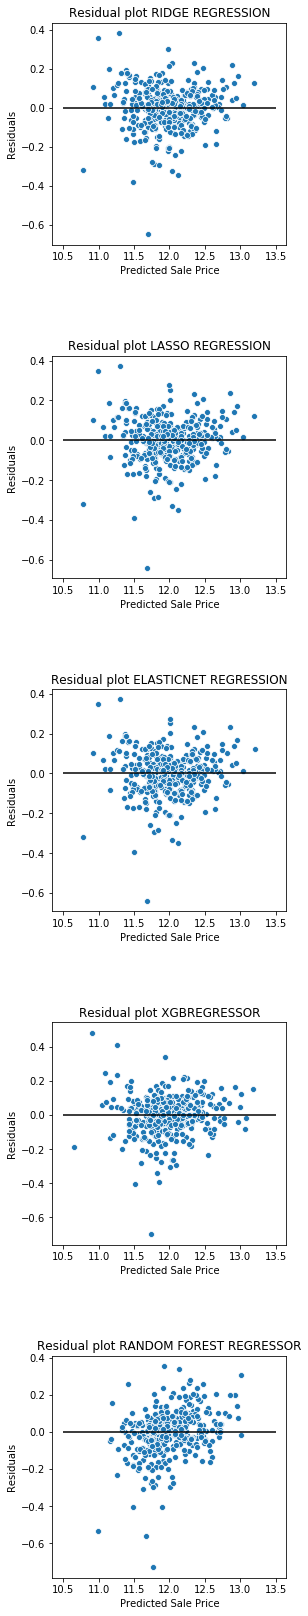

In [55]:
#Wykresy reszt modelu
plt.figure(1)
plt.figure(figsize=(5,30))

plt.subplot(511)
sns.scatterplot(grid1.best_estimator_.predict(X_test),residuals[0])
plt.title('Residual plot RIDGE REGRESSION')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.hlines(0,10.5,13.5)

plt.subplot(512)
sns.scatterplot(grid2.best_estimator_.predict(X_test),residuals[1])
plt.title('Residual plot LASSO REGRESSION')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.hlines(0,10.5,13.5)

plt.subplot(513)
sns.scatterplot(grid3.best_estimator_.predict(X_test),residuals[2])
plt.title('Residual plot ELASTICNET REGRESSION')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.hlines(0,10.5,13.5)

plt.subplot(514)
sns.scatterplot(grid4.best_estimator_.predict(X_test),residuals[3])
plt.title('Residual plot XGBREGRESSOR')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.hlines(0,10.5,13.5)

plt.subplot(515)
sns.scatterplot(grid5.best_estimator_.predict(X_test),residuals[4])
plt.title('Residual plot RANDOM FOREST REGRESSOR')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.hlines(0,10.5,13.5)

plt.subplots_adjust(top=0.92, bottom=0.2, left=0.10, right=0.75, hspace=0.5,
                    wspace=0.5)
plt.show